In [1]:
### Importing the requisite packages

#Data management
import geopandas as gpd
import numpy as np
import pandas as pd

# Visualization
import seaborn
import contextily
import matplotlib.pyplot as plt

# Spatial Statistics
from pointpats import distance_statistics, QStatistic, random, PointPattern, PoissonPointProcess, PoissonClusterPointProcess, Window, poly_from_bbox
import libpysal as ps
from libpysal.cg import shapely_ext

# Setting matplotlib jupyter options to show plots in notebook
%matplotlib inline

In [7]:
### Reading in the data
data_path = r'YOUR FILE PATH'

In [15]:
ohio = gpd.read_file(data_path + 'Ohio\Ohio.shp')
ohio_st = ohio.dissolve()
ohio_st

,geometry,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON
0,"POLYGON ((-83.26787 38.61803, -83.26800 38.617...",39,063,01074044,39063,Hancock,Hancock County,06,H1,G4020,534,22300,None,A,1376125660,6020647,+41.0004711,-083.6660335


In [16]:
# Access shapefile of the state of ohio
oh = ps.io.open(data_path + 'Ohio\Ohio.shp')
polys = [shp for shp in oh]

In [4]:
state = shapely_ext.cascaded_union(polys)

# create window from ohio state boundary
window = Window(state.parts)

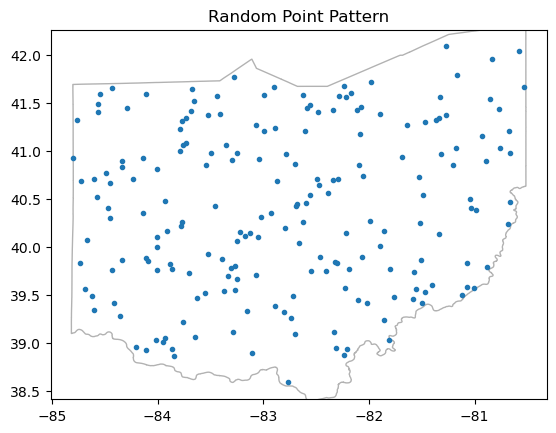

In [5]:
# Here, we're simulating a csr process in the window being Ohio (200 points, 1 realization)
# setting "asPP" True generates a point pattern
# setting "conditioning" to false simulates a N-conditioned CSR
np.random.seed(5)
samples = PoissonPointProcess(window, 200, 1, conditioning=False, asPP=True)

pp_csr = samples.realizations[0] # simulated point pattern

pp_csr.plot(window=True, hull=False, title='Random Point Pattern')

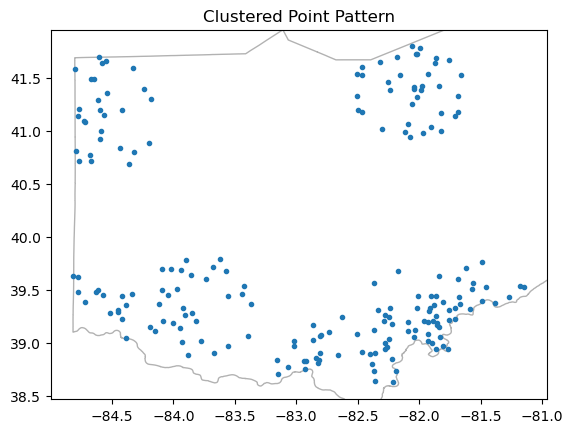

In [6]:
np.random.seed(10)
csamples = PoissonClusterPointProcess(window, 200, 5, 0.5, 1, asPP=True)
pp_pcp = csamples.realizations[0]
pp_pcp.plot(window=True, hull=False, title='Clustered Point Pattern')

In [8]:
# Reading in the data from the path
locs_pdf = pd.read_csv(data_path + 'OSM_DollarGeneralLocs.csv')

# Converting the pandas dataframe into a geopandas geodataframe
locs_gdf = gpd.GeoDataFrame(
    locs_pdf, geometry=gpd.points_from_xy(locs_pdf.X, locs_pdf.Y),
    crs="EPSG:4326"
)

<AxesSubplot:>

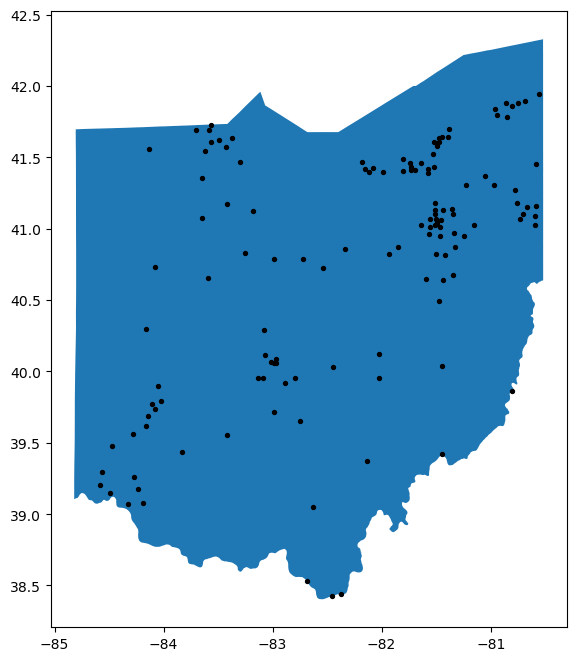

In [9]:
# Create an initial visualization of the data 
f, ax = plt.subplots(1, figsize=(8, 8))
ohio_st.plot(ax = ax,color=None, zorder=1)
locs_gdf.plot(ax = ax, zorder=2, color='black', markersize=8)

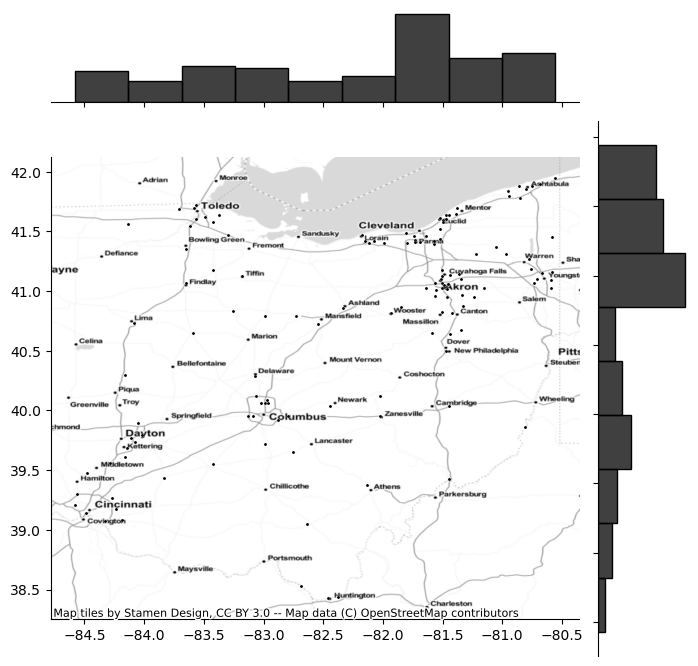

In [10]:
# Create a better visualization
joint_axes = seaborn.jointplot(
    x=locs_gdf.geometry.x, 
    y=locs_gdf.geometry.y, 
    data=locs_gdf, 
    s=5, 
    height=7,
color='k');

contextily.add_basemap(
    joint_axes.ax_joint,
    crs="EPSG:4326",
    source=contextily.providers.Stamen.TonerLite
);


## Ripley's Alphabet

### Ripley's G

In [11]:
g_test = distance_statistics.g_test(
    locs_gdf[['X','Y']].values, support=40, keep_simulations=True
)

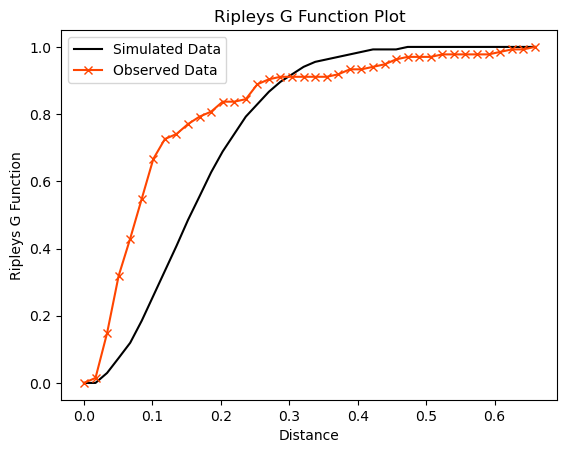

In [12]:
plt.plot(g_test.support, np.median(g_test.simulations, axis=0), 
         color='k', label='Simulated Data')
plt.plot(g_test.support, g_test.statistic, 
         marker='x', color='orangered', label='Observed Data')
plt.legend()
plt.xlabel('Distance')
plt.ylabel('Ripleys G Function')
plt.title('Ripleys G Function Plot')
plt.show()

### Ripley's K

In [13]:
k_test = distance_statistics.k_test(locs_gdf[['X','Y']].values, keep_simulations=True)

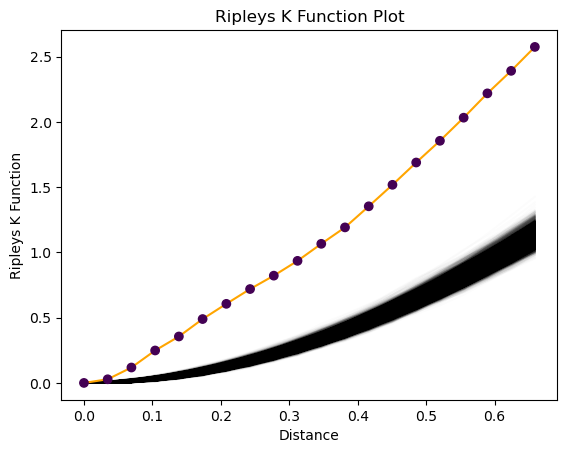

In [14]:
plt.plot(k_test.support, k_test.simulations.T, color='k', alpha=.01)
plt.plot(k_test.support, k_test.statistic, color='orange')

plt.scatter(k_test.support, k_test.statistic, 
            cmap='viridis', c=k_test.pvalue < .05,
            zorder=4
           )

plt.xlabel('Distance')
plt.ylabel('Ripleys K Function')
plt.title('Ripleys K Function Plot')
plt.show()